In [1]:
from xai import *
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import gc
import cv2

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
device = "cuda"

try:
    dqn = DQN.load("dqn-model.pt", device=device)
except FileNotFoundError:
    print("Creating new agent...")
    dqn = DQN(autoencoder_path="asteroids-autoencoder-l32.pt", translate=True, rotate=True, device=device) 

In [10]:
dqn.rewards_per_episode.__len__(), dqn.exploration_rate_per_episode[-1]

(800, 0.2898721500000001)

In [14]:
dqn.train(
    total_time_steps=1_000_000,
    max_episodes=201,
    replay_buffer_size=int(5e6),
    learning_rate = 1e-4,
    learning_starts = 3*6500,
    batch_size = 64,
    tau = 1.0,
    gamma = 0.99,
    train_frequency = 64,
    frame_skip=4,
    gradient_steps = 1,
    episode_save_freq= 25,
    target_update_frequency = 2000,
    final_exploration_rate_progress = 1.0,
    initial_exploration_rate = 0.2898721500000001,
    final_exploration_rate = 0.05,
    verbose = True,
    save_path="dqn-model.pt",
    q_value_head_background_path="states.npy"
)

Filling replay buffer:   0%|          | 0/19500 [00:00<?, ?it/s]

Filling replay buffer: 100%|██████████| 19500/19500 [02:35<00:00, 125.28it/s]
time_step=122635, episode=200, total_reward=110, exploration=0.26:  12%|█▏        | 122636/1000000 [23:34<2:48:36, 86.73it/s] 


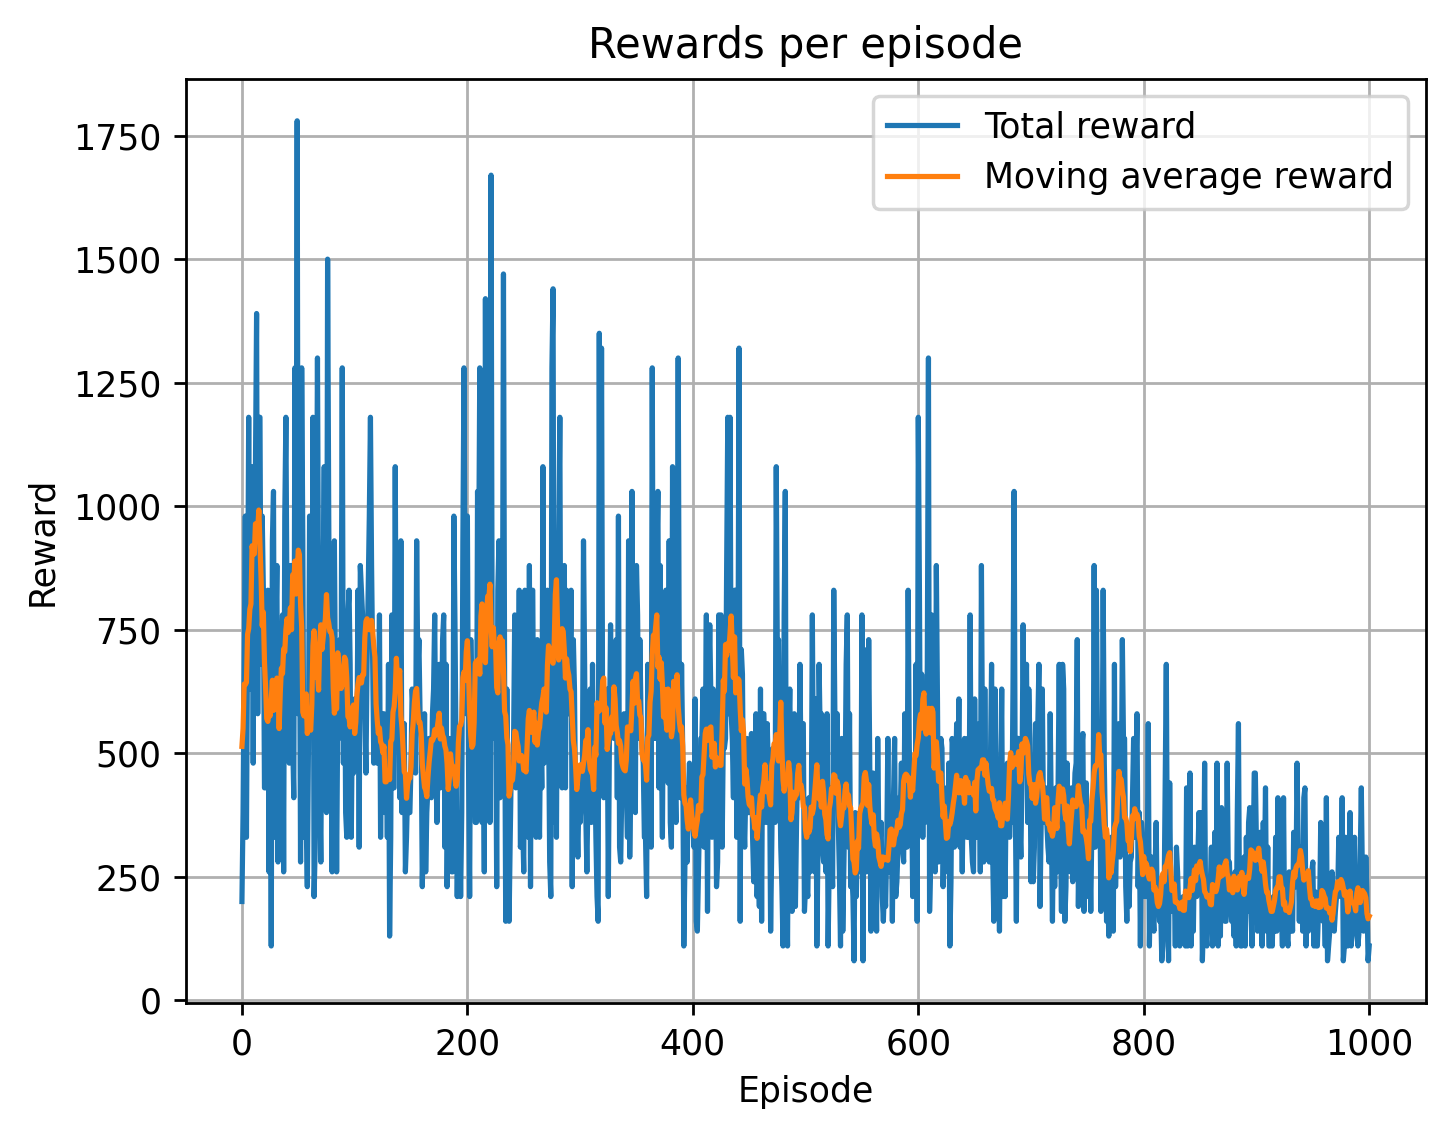

In [43]:
fig = plt.figure(dpi=250)
plt.title("Rewards per episode")
plt.plot(range(len(dqn.rewards_per_episode)), dqn.rewards_per_episode, label="Total reward")
plt.xlabel("Episode")
plt.ylabel("Reward")

avg_rewards = []

for i in range(len(dqn.rewards_per_episode)):
    avg = []
    for i,reward in enumerate(dqn.rewards_per_episode[max(0,i-4):min(i+5, len(dqn.rewards_per_episode))]):
        avg.append(reward)
    avg_rewards.append(sum(avg)/len(avg))

plt.plot(range(len(avg_rewards)), avg_rewards, label="Moving average reward")
plt.legend()
plt.grid()

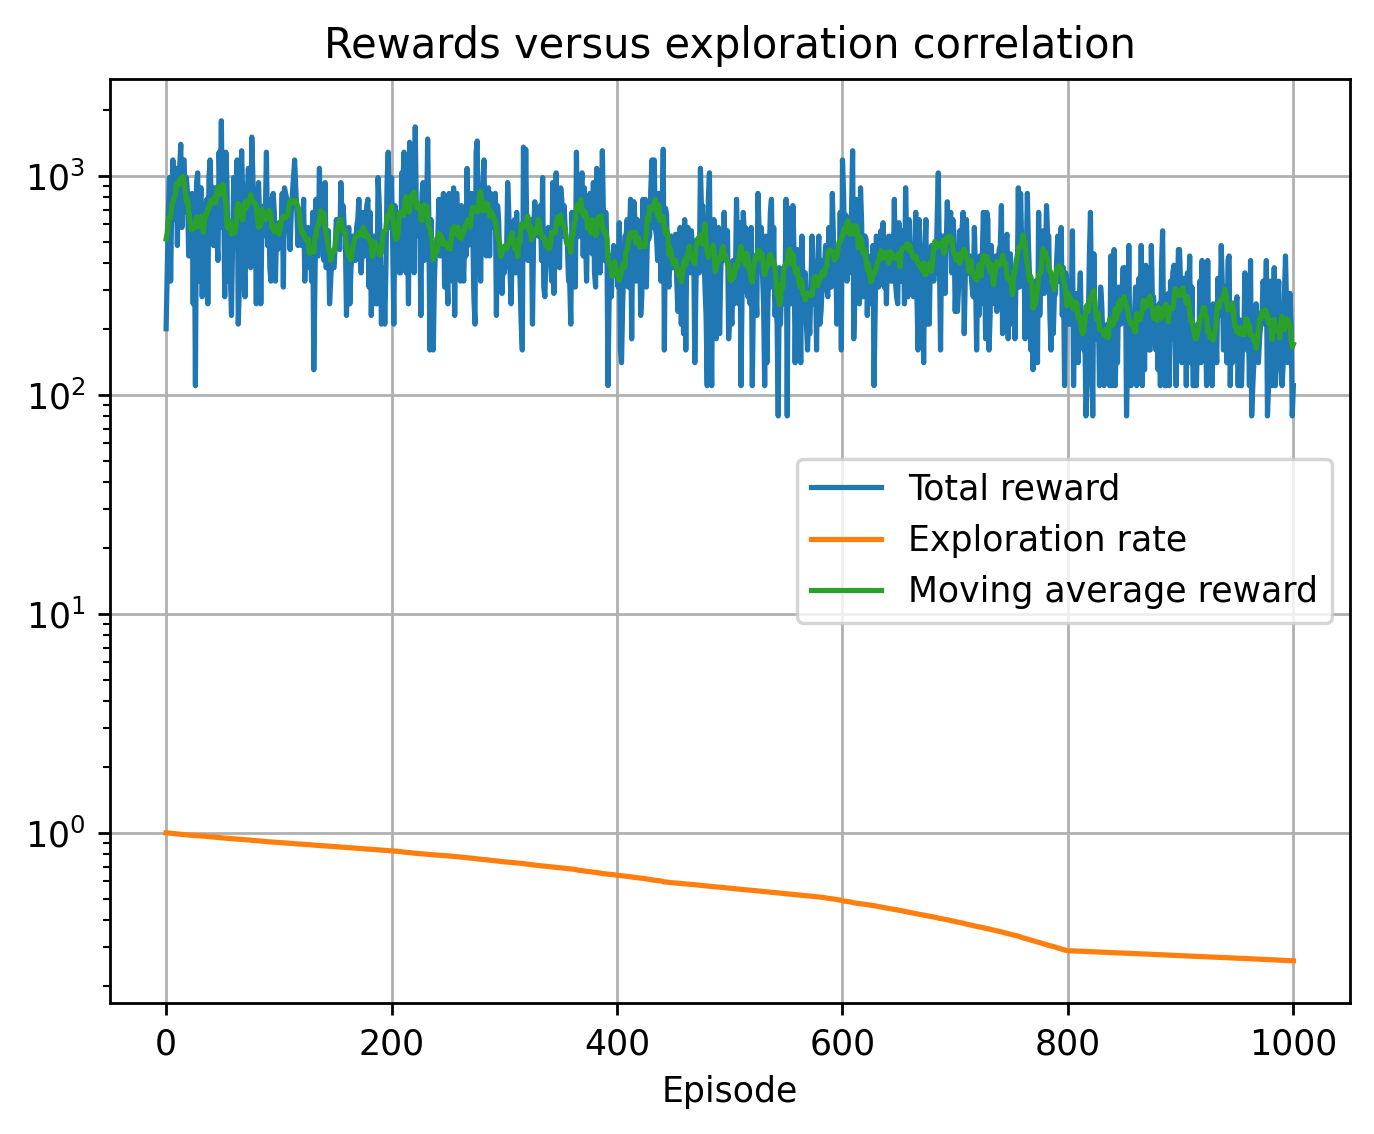

In [44]:
fig = plt.figure(dpi=250)
plt.yscale("log")
plt.title("Rewards versus exploration correlation")
plt.plot(range(len(dqn.rewards_per_episode)), dqn.rewards_per_episode, label="Total reward")
plt.xlabel("Episode")
plt.plot(range(len(dqn.exploration_rate_per_episode)), dqn.exploration_rate_per_episode, label="Exploration rate")

avg_rewards = []

for i in range(len(dqn.rewards_per_episode)):
    avg = []
    for i,reward in enumerate(dqn.rewards_per_episode[max(0,i-4):min(i+5, len(dqn.rewards_per_episode))]):
        avg.append(reward)
    avg_rewards.append(sum(avg)/len(avg))

plt.plot(range(len(avg_rewards)), avg_rewards, label="Moving average reward")
plt.legend()
plt.grid()

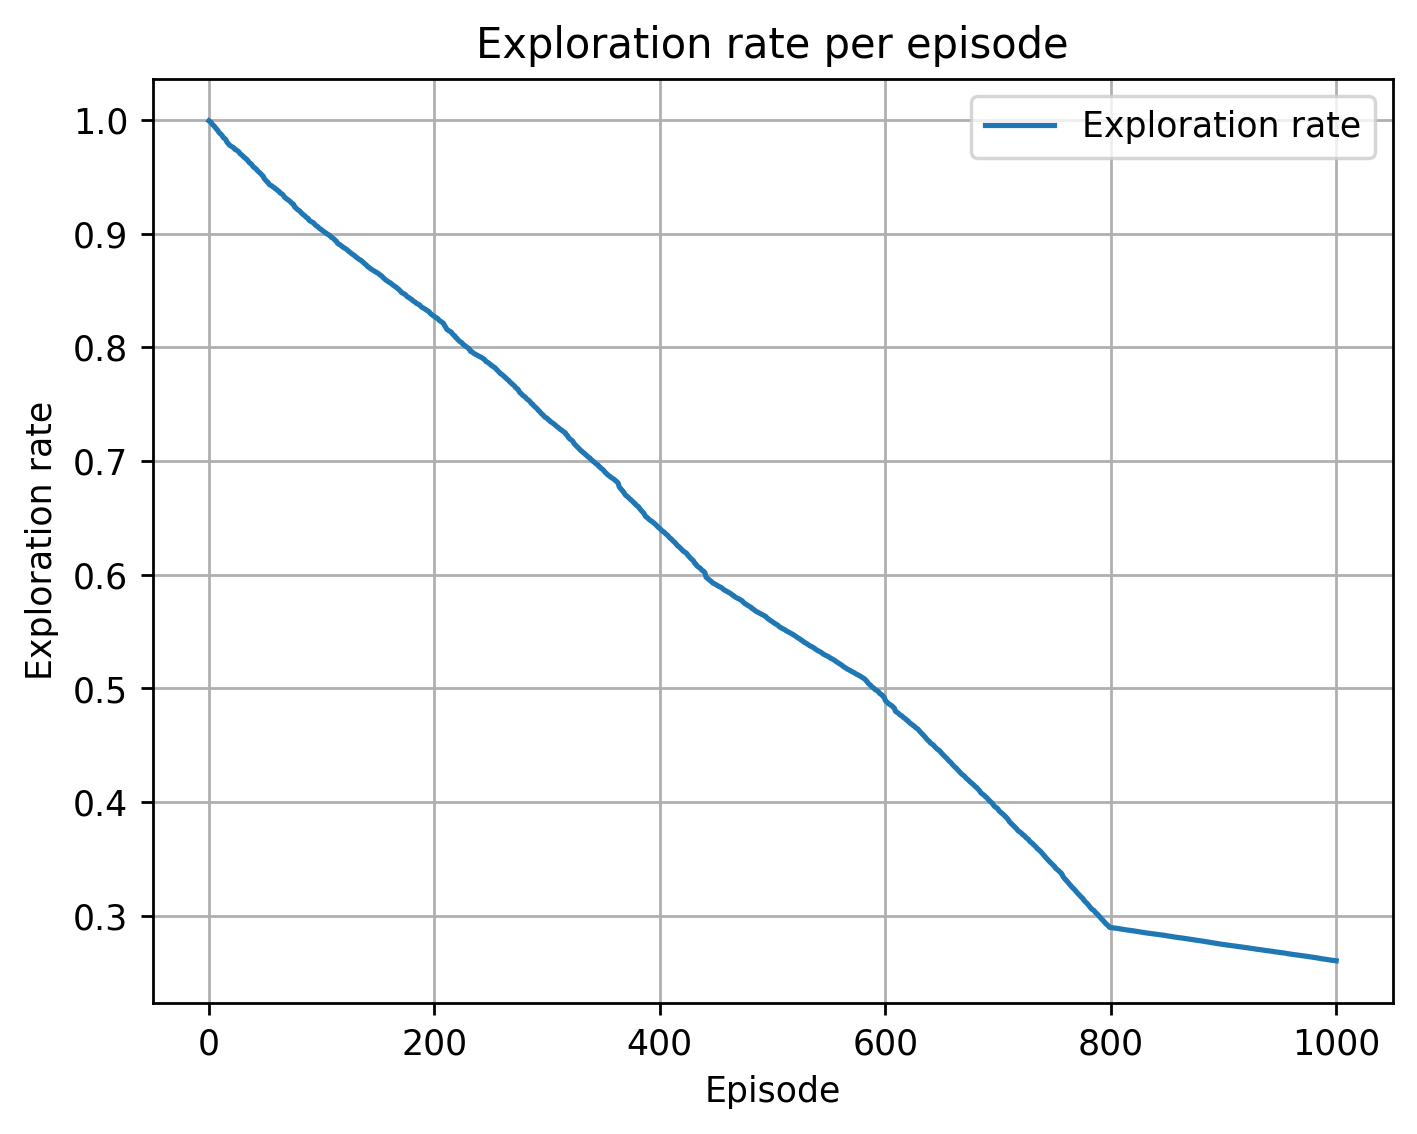

In [45]:
fig = plt.figure(dpi=250)
plt.title("Exploration rate per episode")
plt.xlabel("Episode")
plt.ylabel("Exploration rate")
plt.plot(range(len(dqn.exploration_rate_per_episode)), dqn.exploration_rate_per_episode, label="Exploration rate")
plt.legend()
plt.grid()

In [12]:
with Window("Asteroids", 60, 4.0) as window:
    for step in dqn.rollout(0.3, 4).take(50000):
        window(step.observation.numpy(False))

WindowClosed: 

In [ ]:
plt.plot(range(len(dqn.rewards_per_episode)), dqn.rewards_per_episode, label="Total reward")
plt.plot(range(len(dqn.exploration_rate_per_episode)), dqn.exploration_rate_per_episode, label="Exploration rate")
plt.legend()

In [ ]:
plt.plot(range(len(dqn.rewards_per_episode)), dqn.rewards_per_episode)

In [ ]:
from xai import *
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import gc
import cv2

device = "cpu"

try:
    dqn = DQN.load("dqn-model.pt", device=device)
except FileNotFoundError:
    print("Creating new agent...")
    dqn = DQN(autoencoder_path="asteroids-autoencoder-l32.pt", translate=True, rotate=True, device=device) 

org = (10,4*207)
fontscale = 4
thickness = 3

with Recorder("agent.mp4", scale=4, fps=24) as recorder:
    with Window("Asteroids", 24, 4.0) as window:
        obs_background = dqn._autoencoder.encoder(torch.load("observations.pt")).output()
        state_background = torch.from_numpy(np.load("states.npy"))

        for step in dqn.rollout(0.6, frame_skips=4).take(3000).monitor("Frame:", expected_length=3000):
            gc.collect()
            original = step.observation.numpy(False).repeat(4,0).repeat(4,1)
            transformed = step.observation.translated().rotated().numpy(False)
            reconstruction = dqn._autoencoder(transformed.astype(float)/255.0).output().numpy(force=True)
            transformed = transformed.repeat(4,0).repeat(4,1)
            reconstruction = (reconstruction*255).astype(np.uint8).repeat(4,0).repeat(4,1)
            q_values = dqn._policy(step.next_state).output().numpy(force=True)

            original = cv2.putText(
                img=original, 
                text=f"Original", 
                org=org , 
                fontFace=1,  
                fontScale=fontscale, 
                color=(255,255,255), 
                thickness=thickness, 
                lineType=cv2.LINE_AA
                ) 
            
            transformed = cv2.putText(
                img=transformed, 
                text=f"Observation", 
                org=org , 
                fontFace=1,  
                fontScale=fontscale, 
                color=(255,255,255), 
                thickness=thickness, 
                lineType=cv2.LINE_AA
                ) 
            
            reconstruction = cv2.putText(
                img=reconstruction, 
                text=f"Reconstruction", 
                org=org , 
                fontFace=1,  
                fontScale=fontscale, 
                color=(255,255,255), 
                thickness=thickness, 
                lineType=cv2.LINE_AA
                ) 

            explanations = step.explain(
                algorithm="permutation",
                decoder_background=obs_background[:5],
                q_background=state_background[:5]
            )

            eap_shap_values = explanations.eap_explanation.shap_values

            eap_shap_values = np.append(eap_shap_values, eap_shap_values.sum(0, keepdims=True), axis=0)
            norm = np.max(np.abs(eap_shap_values))

            eap_images = np.zeros((len(eap_shap_values),210,160,3), dtype=np.uint8)
            black = np.zeros_like(eap_shap_values)
            red = np.where(eap_shap_values > 0, eap_shap_values/norm, black)
            blue = np.where(eap_shap_values < 0, -eap_shap_values/norm, black)
            eap_images[:,:,:,0] = (red*255).astype(np.uint8)
            eap_images[:,:,:,2] = (blue*255).astype(np.uint8)

            actions = (
                "NOOP",
                "UP",
                "LEFT",
                "RIGHT",
                "FIRE"
                )

            eap_images = eap_images.repeat(4,1).repeat(4,2)

            for i,eap_image in enumerate(eap_images[:-1]):
                eap_images[i] = cv2.putText(
                    img=eap_images[i], 
                    text=f"Q-{actions[i]}: {q_values[i]:.2f}", 
                    org=org , 
                    fontFace=1,  
                    fontScale=fontscale, 
                    color=(255,255,255), 
                    thickness=thickness, 
                    lineType=cv2.LINE_AA
                    ) 
                
                
            eap_images[-1] = cv2.putText(
                img=eap_images[-1], 
                text=f"Q-sum", 
                org=org , 
                fontFace=1,  
                fontScale=fontscale, 
                color=(255,255,255), 
                thickness=thickness, 
                lineType=cv2.LINE_AA
                ) 

            ecp_shap_values = explanations.ecp_explanation.shap_values

            ecp_shap_values = np.append(ecp_shap_values, ecp_shap_values.sum(0, keepdims=True), axis=0)
            norm = np.max(np.abs(ecp_shap_values))

            ecp_images = np.zeros((len(ecp_shap_values),210,160,3), dtype=np.uint8)

            red = np.where(ecp_shap_values > 0, ecp_shap_values/norm, black)
            blue = np.where(ecp_shap_values < 0, -ecp_shap_values/norm, black)
            ecp_images[:,:,:,0] = (red*255).astype(np.uint8)
            ecp_images[:,:,:,2] = (blue*255).astype(np.uint8)

            ecp_images = ecp_images.repeat(4,1).repeat(4,2)

            for i,ecp_image in enumerate(ecp_images[:-1]):
                ecp_images[i] = cv2.putText(
                    img=ecp_images[i], 
                    text=f"Q-{actions[i]}: {q_values[i]:.2f}", 
                    org=org , 
                    fontFace=1,  
                    fontScale=fontscale, 
                    color=(255,255,255), 
                    thickness=thickness, 
                    lineType=cv2.LINE_AA
                    ) 
                
            ecp_images[-1] = cv2.putText(
                img=ecp_images[-1], 
                text=f"Q-sum", 
                org=org , 
                fontFace=1,  
                fontScale=fontscale, 
                color=(255,255,255), 
                thickness=thickness, 
                lineType=cv2.LINE_AA
                ) 


            l_shap_values = explanations.latent_explanation.flip().shap_values.sum((0,3))
            norm = np.max(np.abs(l_shap_values))

            l_image = np.zeros((210,160,3), dtype=np.uint8)
            black = np.zeros_like(l_shap_values)
            red = np.where(l_shap_values > 0, l_shap_values/norm, black)
            blue = np.where(l_shap_values < 0, -l_shap_values/norm, black)
            l_image[:,:,0] = (red*255).astype(np.uint8)
            l_image[:,:,2] = (blue*255).astype(np.uint8)

            l_image = l_image.repeat(4,0).repeat(4,1)

            l_image = cv2.putText(
                img=l_image, 
                text=f"latent-SHAP", 
                org=org , 
                fontFace=1,  
                fontScale=fontscale, 
                color=(255,255,255), 
                thickness=thickness, 
                lineType=cv2.LINE_AA
                ) 

            black_image = np.zeros_like(original)

            image = np.hstack([
                np.vstack([original,transformed,reconstruction]),
                np.vstack([black_image,l_image,black_image]),
                np.vstack(eap_images[:3]),
                np.vstack(eap_images[3:]),
                np.vstack(ecp_images[:3]),
                np.vstack(ecp_images[3:]),
                ])
            window(image)
            recorder(image)

In [ ]:
videos = {}

obs_background = dqn._autoencoder.encoder(torch.load("observations.pt")).output()
state_background = torch.from_numpy(np.load("states.npy"))

for step in dqn.rollout(0.7, frame_skips=4).take(240).monitor("Frame:", expected_length=3000):
    obs = step.observation.numpy(True)
    videos.setdefault("Original", []).append(step.observation.numpy(False))
    videos.setdefault("Affine", []).append(step.observation.translated().rotated().numpy(False))

    eap_shap_values = step.explain_eap(
        "permutation",
        decoder_background=obs_background[:50],
        q_background=state_background[:50]
    ).shap_values
    shap_sum = eap_shap_values.sum(0)

    norm = max([np.max(np.abs(eap_shap_values)), np.max(np.abs(shap_sum))])

    for i,action_explanation in enumerate(eap_shap_values):
        eap_images = np.zeros((210,160,3), dtype=np.uint8)
        black = np.zeros_like(action_explanation)
        red = np.where(action_explanation > 0, action_explanation/norm, black)
        blue = np.where(action_explanation < 0, -action_explanation/norm, black)
        eap_images[:,:,0] = (red*255).astype(np.uint8)
        eap_images[:,:,2] = (blue*255).astype(np.uint8)
        videos.setdefault(i, []).append(eap_images)

    eap_images = np.zeros((210,160,3), dtype=np.uint8)
    black = np.zeros_like(shap_sum)
    red = np.where(shap_sum > 0, shap_sum/norm, black)
    blue = np.where(shap_sum < 0, -shap_sum/norm, black)
    eap_images[:,:,0] = (red*255).astype(np.uint8)
    eap_images[:,:,2] = (blue*255).astype(np.uint8)
    videos.setdefault("Sum", []).append(eap_images)

        

            

In [ ]:
id_to_action = {
    0: "Noop.mp4",
    1: "Up.mp4",
    2: "Left.mp4",
    3: "Right.mp4",
    4: "Fire.mp4"
}

for i,name in id_to_action.items():
    with Recorder(f"Videos/DQN-EAP-SHAP/{name}", fps=24, scale=4) as recorder:
        for frame in videos[i]:
            recorder(frame)

with Recorder("Videos/DQN-EAP-SHAP/Original.mp4", fps=24, scale=4) as recorder:
    for frame in videos["Original"]:
        recorder(frame)

with Recorder("Videos/DQN-EAP-SHAP/Affine.mp4", fps=24, scale=4) as recorder:
    for frame in videos["Affine"]:
        recorder(frame)

with Recorder("Videos/DQN-EAP-SHAP/Sum.mp4", fps=24, scale=4) as recorder:
    for frame in videos["Sum"]:
        recorder(frame)

with Recorder("Videos/DQN-EAP-SHAP/Combined.mp4", fps=24, scale=3) as recorder:
    for frames in np.moveaxis(np.array(list(videos.values())),1,0):
        recorder(np.hstack(frames))

In [ ]:
with Window("Asteroids", 60, 4.0) as window:
    for i,step in dqn.rollout(0.7, frame_skips=4).take(3000).enumerate():
        window(step.observation.numpy(False))